In [32]:
import pandas as pd
import numpy as np 
from numpy import random

data = pd.read_csv('data/simulation/raw_data.csv')
data

,time,outdoor_temp,zone_temp,occupancy,supply_temp,air_flow
0,7/4/17 0:00,18.0,23.613739,0,24.004024,0.733767
1,7/4/17 0:05,18.0,23.707526,0,25.097556,0.733767
2,7/4/17 0:10,18.0,23.609715,0,24.028751,0.733767
3,7/4/17 0:15,18.0,23.701950,0,25.087994,0.733767
4,7/4/17 0:20,18.0,23.813668,0,25.000012,0.733767
...,...,...,...,...,...,...
283,7/4/17 23:35,18.0,23.610241,0,23.910552,0.700497
284,7/4/17 23:40,18.0,23.717024,0,25.137926,0.733767
285,7/4/17 23:45,18.0,23.613074,0,23.961551,0.733767
286,7/4/17 23:50,18.0,23.712799,0,25.111871,0.733767


In [145]:
##Faults:
# 1. Offset Fault: x' = a + x + err
# 2. Gain Fault: x' = Bx+ err
# 3. Stuck at Fault: x' = a
# 4. Out-of-bound: x'<theta1 and x'>theta2

#true_values refers to the 

def simulateFault(sensedValues, fault_type, params, fault_rate):
    true_values = []
    classification = []
    k = 0
    if fault_type == 1:
        a = params['constant']
        end_index = fault_rate * len(sensedValues)
        noise = random.rand(len(sensedValues)) * 0.5
        for i in range(0,len(sensedValues)):
            if i <= end_index:
                true_values.append(noise[i] + a + sensedValues[i])
                classification.append(1)
            else:
                if k == 0:
                    k = i
                true_values.append(noise[i] + sensedValues[i])
                classification.append(0)
    elif fault_type == 2:
        B = params['coeff']
        end_index = fault_rate * len(sensedValues)
        noise = random.rand(len(sensedValues)) * 0.5
        for i in range(0,len(sensedValues)):
            if i <= end_index:
                true_values.append(noise[i] + B * sensedValues[i])
                classification.append(1)
            else:
                if k == 0:
                    k = i
                true_values.append(noise[i] + sensedValues[i])
                classification.append(0)
    
    elif fault_type == 3:
        end_index = fault_rate * len(sensedValues)
        noise = random.rand(len(sensedValues)) * 0.5
        for i in range(0,len(sensedValues)):
            if i <= end_index:
                true_values.append(sensedValues[i])
                classification.append(1)
            else:
                if k == 0:
                    k = i
                true_values.append(noise[i] + sensedValues[i])
                classification.append(0)
    #print(k)
    return true_values, classification

In [153]:
#Import svm model
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics

rates = [0.1,0.2,0.3,0.4,0.5]
DA = {}
#### SIMULATING OFFSET FAULT
i = 0.1
acc = []

while i <= 0.5:
    supply_temp = data['supply_temp'].tolist()
    true_supply_temp, label = simulateFault(supply_temp, 1, {'constant': 1.25}, i)
    processed_data = pd.DataFrame({'sensed': supply_temp, 'true_sensed': true_supply_temp, 'label':label})
    processed_data

    #Create a svm Classifier
    clf = svm.SVC(kernel='linear') # Linear Kernel

    x = processed_data[['sensed','true_sensed']]
    y = processed_data['label']

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, shuffle = True)
    # print(x_train)
    # print(y_train)

    #Train the model using the training sets
    clf.fit(x_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(x_test)
    acc.append(metrics.accuracy_score(y_test, y_pred)*100)
    
    i = i + 0.1

DA['offset'] = acc

#### SIMULATING GAIN FAULT

i = 0.1
acc = []
while i <= 0.5:
    supply_temp = data['supply_temp'].tolist()
    true_supply_temp, label = simulateFault(supply_temp, 2, {'coeff': 1.25}, i)
    processed_data = pd.DataFrame({'sensed': supply_temp, 'true_sensed': true_supply_temp, 'label':label})
    processed_data

    #Create a svm Classifier
    clf = svm.SVC(kernel='linear') # Linear Kernel

    x = processed_data[['sensed','true_sensed']]
    y = processed_data['label']

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, shuffle = True)
    # print(x_train)
    # print(y_train)

    #Train the model using the training sets
    clf.fit(x_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(x_test)
    acc.append(metrics.accuracy_score(y_test, y_pred)*100)
    
    i = i + 0.1

DA['gain'] = acc

#### SIMULATING STUCK AT FAULT

i = 0.1
acc = []
while i <= 0.5:
    supply_temp = data['supply_temp'].tolist()
    true_supply_temp, label = simulateFault(supply_temp, 3, {'coeff': 1.25}, i)
    processed_data = pd.DataFrame({'sensed': supply_temp, 'true_sensed': true_supply_temp, 'label':label})
    processed_data

    #Create a svm Classifier
    clf = svm.SVC(kernel='linear') # Linear Kernel

    x = processed_data[['sensed','true_sensed']]
    y = processed_data['label']

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, shuffle = True)
    # print(x_train)
    # print(y_train)

    #Train the model using the training sets
    clf.fit(x_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(x_test)
    acc.append(metrics.accuracy_score(y_test, y_pred)*100)
    i = i + 0.1

DA['stuck'] = acc
print(DA)
#print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
#print(y_test.tolist())
#print(y_pred.tolist())

{'offset': [100.0, 100.0, 100.0, 100.0, 100.0], 'gain': [100.0, 100.0, 100.0, 100.0, 100.0], 'stuck': [87.5, 90.625, 88.54166666666666, 84.375, 79.16666666666666]}


In [154]:
result = pd.DataFrame(DA)
result

,offset,gain,stuck
0,100.0,100.0,87.500000
1,100.0,100.0,90.625000
2,100.0,100.0,88.541667
3,100.0,100.0,84.375000
4,100.0,100.0,79.166667


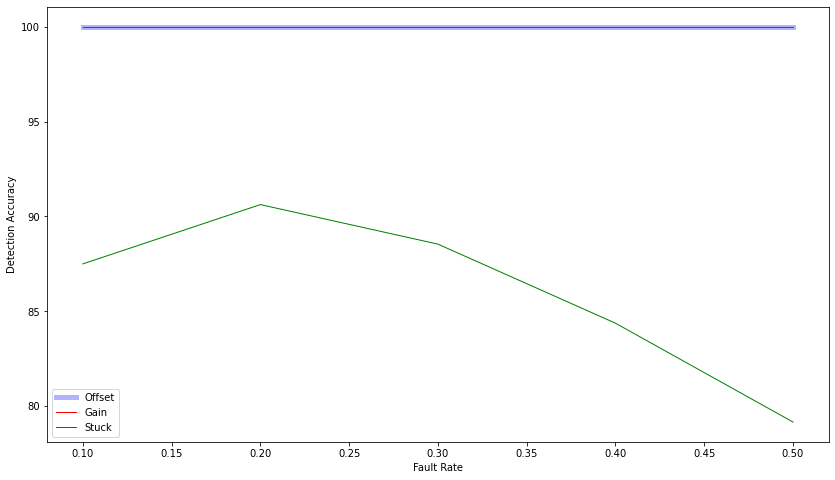

In [167]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(rates, result['offset'], "blue", linewidth=5, alpha=0.3, label = 'Offset')
ax.plot(rates, result['gain'], "red", linewidth=1, label = 'Gain')
ax.plot(rates, result['stuck'], "green", linewidth=1, label = 'Stuck')
ax.set_ylabel('Detection Accuracy')
ax.set_xlabel('Fault Rate')
fig.set_size_inches(14, 8)
plt.legend()
plt.show()